### Class 2 - Modeling problems

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

In [2]:
import statsmodels
import statsmodels.api as sm

In [6]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Personality and random numbers
We will focus on predicting random number choices from personality scores.
**Outcome (Y)**, choose one: 
    - `R18`, i.e., last choice of a number between 1 and 100
    - Binned versions of `R18` (quantiles? extremes - middle - other? round versus other?)
    - **Bonus**: predict multiple responses at once
**Models**:
    - Model 0: Always predict the _median_ (or _mode_?) of Y on the training data
    - Model 1a: Predict Y based on other answers to 1-100 questions
    - Model 1b: Predict Y based on other random number picks
    - Model 2: Include personality scores as predictors 

In [9]:
rn = ('/work/Project Files/data/class_01/randomnumber.csv')
rn = pd.read_csv(rn)

rn.describe

<bound method NDFrame.describe of                submittime  R1   R2  R3   R4  R5    R6  R7  R8  R9  ...  O1  \
0     2015-03-29 10:29:36  56  786  48  479  23   632  31  38  61  ...   4   
1     2015-03-29 06:24:30   5  500  77  102  65  1223  50  16  14  ...   5   
2     2015-03-29 02:40:41   8   18  88  666  28  1233  99  27   2  ...   4   
3     2015-03-28 10:17:47  99  999  98  499  99  1233  99  49  99  ...   4   
4     2015-03-28 10:15:47  40  500  77  200  50   133  70  17  80  ...   3   
...                   ...  ..  ...  ..  ...  ..   ...  ..  ..  ..  ...  ..   
1364  2015-03-31 11:39:47  60  400  65  200  34   789  57  30  34  ...   5   
1365  2015-03-31 11:36:31  34  783  55  397  55   400  52  49  52  ...   5   
1366  2015-03-31 11:37:28  50   50  55  454  50   130  99  34  34  ...   5   
1367  2015-03-31 11:43:53  99  999  66  266  89  1099  77  49  88  ...   5   
1368  2015-03-31 11:46:30  42   74  64  101  63  1000  11  23  68  ...   5   

      O2  O3  O4  O5  O6  O7 

## Bike sharing
Let's focus on predicting the number of users based on weather and temporal information
**Outcome (Y)**, choose one:
- Total number of bikers `cnt`
- Count of casual or registered users (`casual` or `registered`)
- Bonus: the difference or ratio between registered and casual
**Models**
    - Model 0: Always predict the average of Y in the training data
    - Model 1: Predict based on a linear model with `instant` as the only predictor
    - Model 2: Model including weather info (temperature, windspeed) and temporal parameters (e.g., `season`, `weekday`) as predictors
    - Bonus: A "kitchen sink" model, will all predictors included

### Bike: Linear Regression Prediction (https://www.analyticsvidhya.com/blog/2023/05/end-to-end-case-study-bike-sharing-demand-prediction/)

In [29]:
bike = ('/work/Project Files/data/class_01/bikes.csv')
bike = pd.read_csv(bike)

In [13]:
print(bike.shape) # (17379, 17)
print(bike.describe)
print(bike.columns)

(17379, 17)
<bound method NDFrame.describe of        instant      dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  2011-01-01       1   0     1   0        0        6   
1            2  2011-01-01       1   0     1   1        0        6   
2            3  2011-01-01       1   0     1   2        0        6   
3            4  2011-01-01       1   0     1   3        0        6   
4            5  2011-01-01       1   0     1   4        0        6   
...        ...         ...     ...  ..   ...  ..      ...      ...   
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
0               0           1  0.24  0.28

In [28]:
print(bike.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


In [32]:
bike.info()
# bike.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


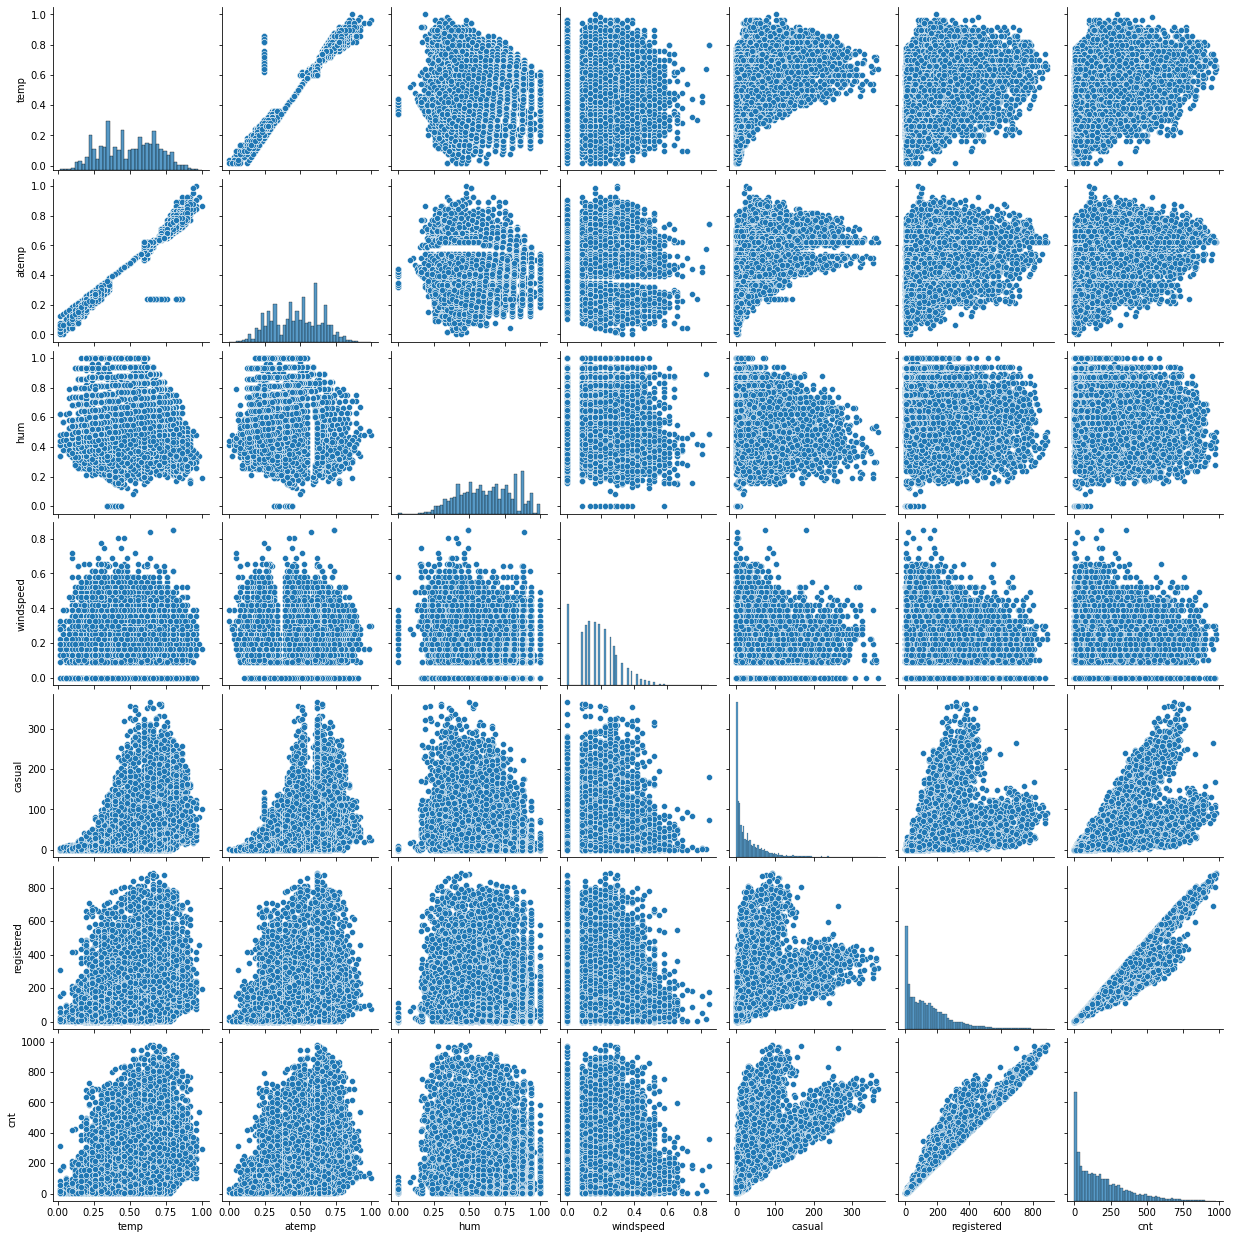

In [33]:
# visualise data
sns.pairplot(bike[["temp","atemp","hum","windspeed","casual","registered","cnt"]])
plt.show()

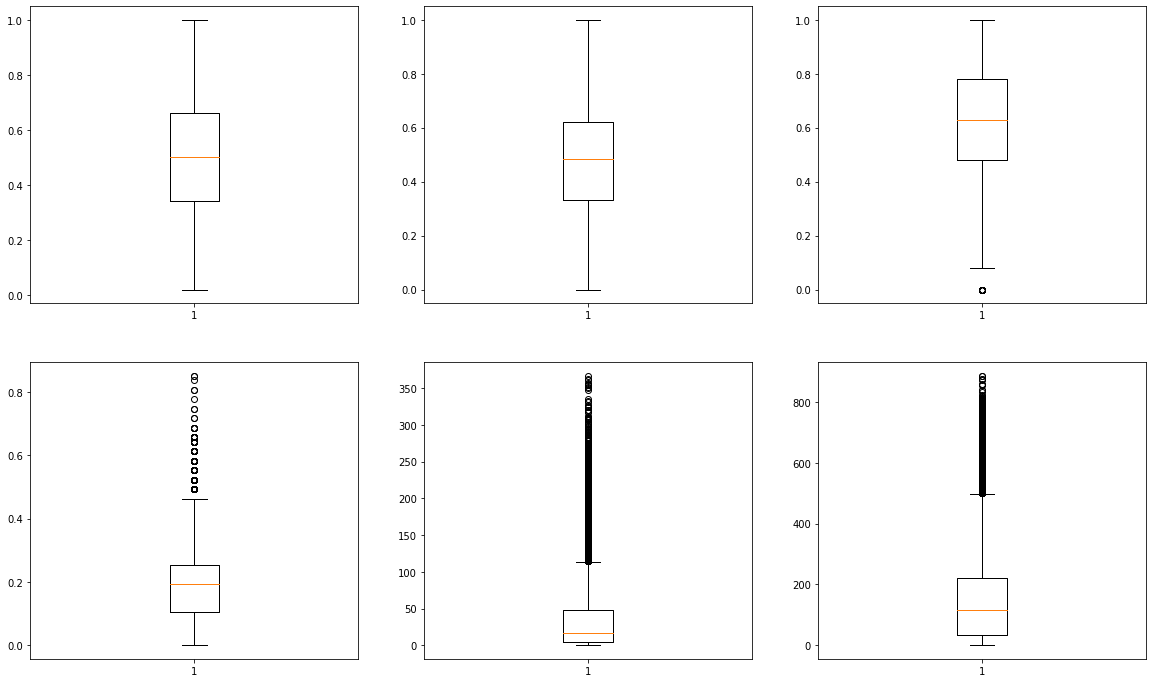

In [35]:
#Plotting box plot of continuous variables

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
plt.boxplot(bike["temp"])
plt.subplot(2,3,2)
plt.boxplot(bike["atemp"])
plt.subplot(2,3,3)
plt.boxplot(bike["hum"])
plt.subplot(2,3,4)
plt.boxplot(bike["windspeed"])
plt.subplot(2,3,5)
plt.boxplot(bike["casual"])
plt.subplot(2,3,6)
plt.boxplot(bike["registered"])
plt.show()

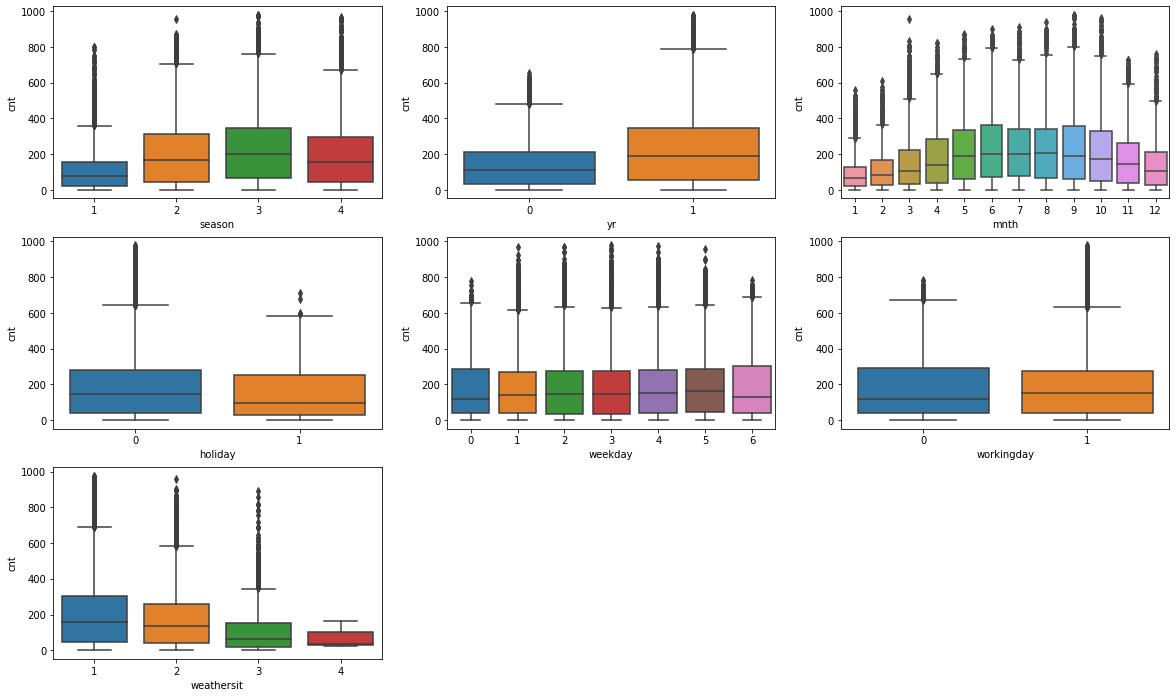

In [36]:
# visualising categorical data
#Plotting box plot of categorical variables

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(3,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(3,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(3,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.subplot(3,3,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.show()

Dropping unnecessary columns instant, dteday, casual & registered

instant – It is just a sequence number of rows
dteday – It is not required since columns for year & month already exists
casual – This variable cannot be predicted.
registered – This variable cannot be predicted.

In [37]:
bike.drop(columns=["instant","dteday","casual","registered"],axis=1,inplace =True)
bike.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [38]:
# dummy variables
season_type = pd.get_dummies(bike['season'], drop_first = True)
season_type.rename(columns={2:"season_summer", 3:"season_fall", 4:"season_winter"},inplace=True)
season_type.head()


,season_summer,season_fall,season_winter
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [39]:
weather_type = pd.get_dummies(bike['weathersit'], drop_first = True)
weather_type.rename(columns={2:"weather_mist_cloud", 3:"weather_light_snow_rain"},inplace=True)
weather_type.head()

,weather_mist_cloud,weather_light_snow_rain,4
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [40]:
#Concatenating new dummy variables to the main dataframe
bike = pd.concat([bike, season_type, weather_type], axis = 1)

#Dropping columns season & weathersit since we have already created dummies for them
bike.drop(columns=["season", "weathersit"],axis=1,inplace =True)

#Analysing dataframe after dropping columns
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   yr                       17379 non-null  int64  
 1   mnth                     17379 non-null  int64  
 2   hr                       17379 non-null  int64  
 3   holiday                  17379 non-null  int64  
 4   weekday                  17379 non-null  int64  
 5   workingday               17379 non-null  int64  
 6   temp                     17379 non-null  float64
 7   atemp                    17379 non-null  float64
 8   hum                      17379 non-null  float64
 9   windspeed                17379 non-null  float64
 10  cnt                      17379 non-null  int64  
 11  season_summer            17379 non-null  uint8  
 12  season_fall              17379 non-null  uint8  
 13  season_winter            17379 non-null  uint8  
 14  weather_mist_cloud    

In [41]:
# create derived variables 'year quarter' for the categorical variable months 
#Creating year_quarter derived columns from month columns.
#Note that last quarter has not been created since we need only 3 columns to define the four quarters.

bike["Quarter_JanFebMar"] = bike["mnth"].apply(lambda x: 1 if x<=3 else 0)
bike["Quarter_AprMayJun"] = bike["mnth"].apply(lambda x: 1 if 4<=x<=6 else 0)
bike["Quarter_JulAugSep"] = bike["mnth"].apply(lambda x: 1 if 7<=x<=9 else 0)

#Dropping column mnth since we have already created dummies.

bike.drop(columns=["mnth"],axis=1,inplace =True)
bike["weekend"] = bike["weekday"].apply(lambda x: 0 if 1<=x<=5 else 1)
bike.drop(columns=["weekday"],axis=1,inplace =True)
bike.drop(columns=["workingday"],axis=1,inplace =True)
bike.head()

,yr,hr,holiday,temp,atemp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weather_mist_cloud,weather_light_snow_rain,4,Quarter_JanFebMar,Quarter_AprMayJun,Quarter_JulAugSep,weekend
0,0,0,0,0.24,0.2879,0.81,0.0,16,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0.22,0.2727,0.80,0.0,40,0,0,0,0,0,0,1,0,0,1
2,0,2,0,0.22,0.2727,0.80,0.0,32,0,0,0,0,0,0,1,0,0,1
3,0,3,0,0.24,0.2879,0.75,0.0,13,0,0,0,0,0,0,1,0,0,1
4,0,4,0,0.24,0.2879,0.75,0.0,1,0,0,0,0,0,0,1,0,0,1


In [43]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   yr                       17379 non-null  int64  
 1   hr                       17379 non-null  int64  
 2   holiday                  17379 non-null  int64  
 3   temp                     17379 non-null  float64
 4   atemp                    17379 non-null  float64
 5   hum                      17379 non-null  float64
 6   windspeed                17379 non-null  float64
 7   cnt                      17379 non-null  int64  
 8   season_summer            17379 non-null  uint8  
 9   season_fall              17379 non-null  uint8  
 10  season_winter            17379 non-null  uint8  
 11  weather_mist_cloud       17379 non-null  uint8  
 12  weather_light_snow_rain  17379 non-null  uint8  
 13  4                        17379 non-null  uint8  
 14  Quarter_JanFebMar     

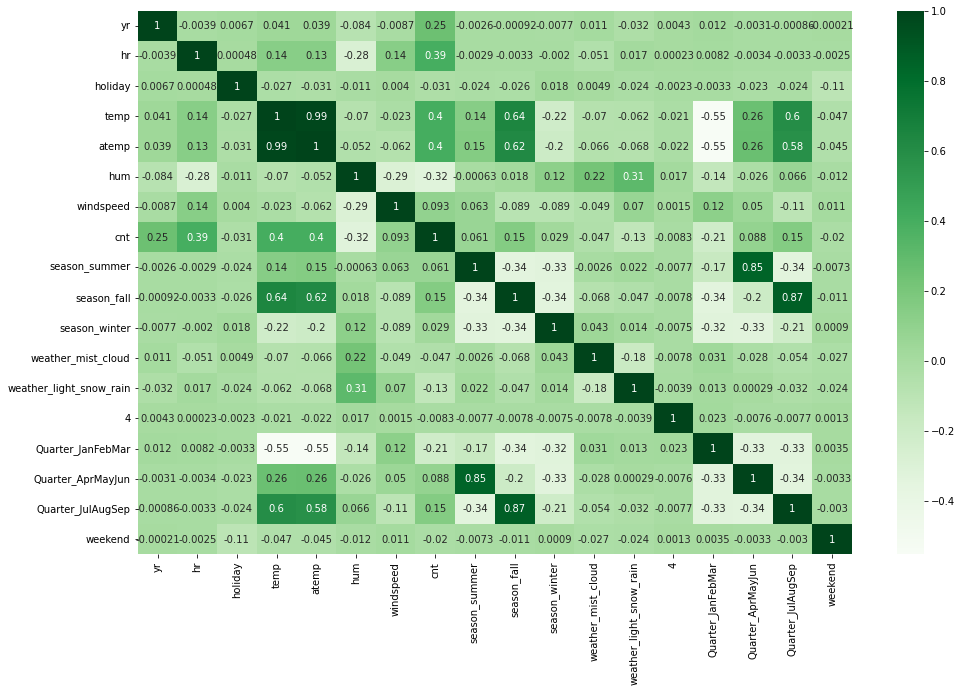

In [44]:
#Plotting correlation heatmap to analyze the linearity between the variables in the dataframe 

plt.figure(figsize = (16, 10))
sns.heatmap(bike.corr(), annot = True, cmap="Greens")
plt.show()

In [45]:
#Dropping column temp since it is very highly collinear with the column atemp.
#Further,the column atemp is more appropriate for modelling compared to column temp from human perspective.

bike.drop(columns=["temp"],axis=1,inplace =True)
bike.head()

,yr,hr,holiday,atemp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weather_mist_cloud,weather_light_snow_rain,4,Quarter_JanFebMar,Quarter_AprMayJun,Quarter_JulAugSep,weekend
0,0,0,0,0.2879,0.81,0.0,16,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0.2727,0.80,0.0,40,0,0,0,0,0,0,1,0,0,1
2,0,2,0,0.2727,0.80,0.0,32,0,0,0,0,0,0,1,0,0,1
3,0,3,0,0.2879,0.75,0.0,13,0,0,0,0,0,0,1,0,0,1
4,0,4,0,0.2879,0.75,0.0,1,0,0,0,0,0,0,1,0,0,1


In [46]:
## splitting data into train and test
#Importing library

from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
bike_train, bike_test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 100)


In [49]:
# rescale (minmax) to get features in same range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Applying scaler to all the columns except the derived and 'dummy' variables that are already in 0 & 1.

numeric_var = ['atemp','hum','windspeed','cnt']
bike_train[numeric_var] = scaler.fit_transform(bike_train[numeric_var])

# Analysing the train dataframe after scaling
bike_train.head()

,yr,hr,holiday,atemp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weather_mist_cloud,weather_light_snow_rain,4,Quarter_JanFebMar,Quarter_AprMayJun,Quarter_JulAugSep,weekend
8364,0,4,0,0.369212,0.53,0.122840,0.003074,0,0,1,1,0,0,0,0,0,0
643,0,2,0,0.230808,0.80,0.000000,0.010246,0,0,0,0,0,0,1,0,0,1
9518,1,13,0,0.399980,0.40,0.263195,0.143443,0,0,0,0,0,0,1,0,0,0
7233,0,0,0,0.369212,0.76,0.105325,0.030738,0,0,1,0,0,0,0,0,0,0
7443,0,18,1,0.323111,0.39,0.298225,0.212090,0,0,1,0,0,0,0,0,0,0


In [50]:
y_train = bike_train.pop('cnt')
X_train = bike_train

print (y_train.head())
print (X_train.head())

8364    0.003074
643     0.010246
9518    0.143443
7233    0.030738
7443    0.212090
Name: cnt, dtype: float64
      yr  hr  holiday     atemp   hum  windspeed  season_summer  season_fall  \
8364   0   4        0  0.369212  0.53   0.122840              0            0   
643    0   2        0  0.230808  0.80   0.000000              0            0   
9518   1  13        0  0.399980  0.40   0.263195              0            0   
7233   0   0        0  0.369212  0.76   0.105325              0            0   
7443   0  18        1  0.323111  0.39   0.298225              0            0   

      season_winter  weather_mist_cloud  weather_light_snow_rain  4  \
8364              1                   1                        0  0   
643               0                   0                        0  0   
9518              0                   0                        0  0   
7233              1                   0                        0  0   
7443              1                   0              

In [52]:
## build linear model to predict bike demand, train it on training data and optimise to minimise error

from sklearn.feature_selection import RFE # recursive feature elimination
from sklearn.linear_model import LinearRegression
# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12) # running RFE
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))


TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [53]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[columns_rfe]
X_train_rfe

NameError: name 'columns_rfe' is not defined

### Bike: https://www.kaggle.com/code/lakshmi25npathi/bike-rental-count-prediction-using-python